In [87]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [88]:
#read in data set and set proper shape 
player = pd.read_csv("Fox.csv", header = 1).set_index("Rk")

In [89]:
# how variable is our data
player['PTS'].describe()

count    99.000000
mean     23.494949
std       7.945444
min       8.000000
25%      17.000000
50%      24.000000
75%      29.000000
max      44.000000
Name: PTS, dtype: float64

<AxesSubplot:>

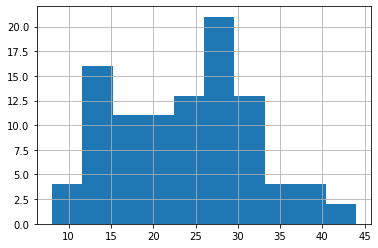

In [90]:
# how variable is our data
player['PTS'].hist()

In [91]:
# rename unnamed col indicating home or away 
player = player.rename(columns = {"Unnamed: 5": "Home"})

In [92]:
# change @ to binary home or away 
player['Home'] = player['Home'].replace(np.nan, 1)
player['Home'] = player['Home'].replace('@', 0)

In [93]:
# Keep desired columns
player = player[['Date', 'Opp', 'Home', 'MP', 'FG%', 'FTA', 'PTS']]

In [94]:
# convert string to date time format
format = '%Y-%m-%d'  
player['Date'] = player['Date'].apply(lambda x: datetime.strptime(x, format))

In [95]:
# add the points of the next game at end along with current game known data 
next_game_pts = player['PTS'].shift(1)
next_game_opp = player['Opp'].shift(1)
next_game_date = player['Date'].shift(1)
next_game_home = player['Home'].shift(1)

player["curr_opp"] = next_game_opp
player['curr_timestamp'] = next_game_date
player["curr_pts"] = next_game_pts
player["curr_h"] = next_game_home

In [96]:
# rename to more logical 
player = player.rename(columns = {"Date": "days_since_0", 'Opp': 'opp_0', 'Home':'h_0', 'MP': 'mp_0', 'FG%': 'fg%_0',
                                 'FTA': 'fta_0', 'PTS': 'pts_0'})

In [97]:
# create function that adds a desired amount of games as previous data 
# also convert timestamp to time since game

def add_prev_games(x, player):
    
    player_copy = player.copy()
    player_copy = player_copy.drop(columns =["curr_pts", "curr_opp",'curr_timestamp', 'curr_h'])
    df_list = [player]
    
    for i in range(1,x+1):
        player_copy = player_copy.shift(-i)
        player_copy = player_copy.rename(columns = {'days_since_0':'days_since_'+str(i) , 'opp_0':'opp_'+str(i) , 
                                                    'h_0': 'h_'+str(i), 'mp_0': 'mp_'+str(i), 
                                                    'fg%_0': 'fg%_'+str(i),'fta_0': 'fta_'+str(i), 
                                                    'pts_0':'pts_'+str(i)})
        df_list.insert(0, player_copy)
        player_copy = player.copy()
        player_copy = player_copy.drop(columns =["curr_pts", "curr_opp",'curr_timestamp', 'curr_h'])
    
    merged = pd.concat(df_list, axis=1, join="inner")
    merged = merged.iloc[1:-x,:].reset_index()
    merged = merged.drop(columns = 'Rk')
    
    
    #converts time to time since game  
    for i in range(0,x+1):
        merged['days_since_'+str(i)] = (merged['curr_timestamp'] - merged['days_since_'+str(i)]).apply(lambda x: x.days)
        
    merged = merged.drop(columns =["curr_timestamp"])
    
    return merged    

In [98]:
player = add_prev_games(3, player) 

<AxesSubplot:>

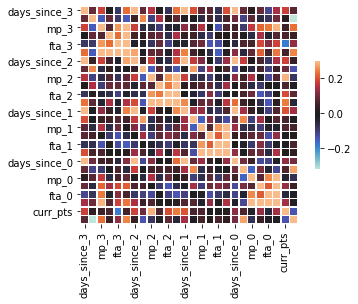

In [99]:
# correlation matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(player.corr(), vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [100]:
# create dummies
player = pd.get_dummies(player)

In [101]:
# create test and train splits 
X = player.drop(columns = "curr_pts")
y = player.curr_pts.values
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [102]:
# Simple Linear Regression 
lm = LinearRegression()
np.mean(cross_val_score(lm, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 4))

-9.01438574368073

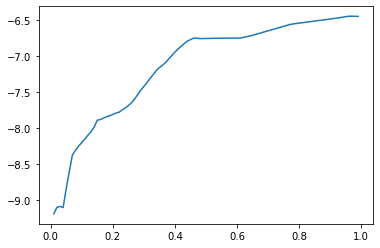

In [103]:
# Lasso Regression

# Takes a second to run but used to finds the best alpha 

alpha = []
error = []
for i in range(1,100):
    alpha.append(i/100)
    lml = Lasso(alpha=(i/100))
    error.append(np.mean(cross_val_score(lml,X_train,y_train, scoring = 'neg_mean_absolute_error', cv= 2)))
plt.plot(alpha,error)

In [104]:
best_alpha = pd.DataFrame(zip(alpha, error))[0][98]
lm_l = Lasso(alpha = best_alpha)
np.mean(cross_val_score(lm_l,X_train,y_train, scoring = 'neg_mean_absolute_error', cv = 2))

-6.4461357197798375

In [105]:
# Random Forest 
rf = RandomForestRegressor()
np.mean(cross_val_score(rf,X_train,y_train,scoring = 'neg_mean_absolute_error', cv = 2))

-6.300657894736842

In [106]:
# Tuning to find optimal hyper parameters 
parameters = {'n_estimators':range(10,300,10), 'criterion':('mse','mae'), 'max_features':('auto','sqrt','log2')}
gs = GridSearchCV(rf,parameters,scoring='neg_mean_absolute_error',cv=2)
gs.fit(X_train,y_train)
gs.best_score_
gs.best_estimator_

RandomForestRegressor(criterion='mae', max_features='sqrt', n_estimators=80)

In [107]:
np.mean(cross_val_score(gs.best_estimator_,X_train,y_train,scoring = 'neg_mean_absolute_error', cv = 2))

-6.113815789473684

In [108]:
# Fitting all models 
lm.fit(X_train,y_train)
lm_l.fit(X_train,y_train)
rf.fit(X_train,y_train)

RandomForestRegressor()

In [109]:
# Predict y values with models  
tpred_lm = lm.predict(X_test)
tpred_lml = lm_l.predict(X_test)
tpred_rf = rf.predict(X_test)
tpred_gs = gs.predict(X_test)

In [110]:
# Test Scores

print("Basic Linear Regression Scores: " + str(mean_absolute_error(y_test,tpred_lm)))
print("Lasso Regression Scores: " + str(mean_absolute_error(y_test,tpred_lml)))
print("Random Forest Before Tuning Scores: " + str(mean_absolute_error(y_test,tpred_rf)))
print("Tuned Random Forest Scores: "+ str(mean_absolute_error(y_test,tpred_gs)))

Basic Linear Regression Scores: 8.966138736149253
Lasso Regression Scores: 7.5676393783255005
Random Forest Before Tuning Scores: 8.367368421052632
Tuned Random Forest Scores: 8.0625


In [111]:
# Combining two models 

print("Combining lm and gs gives: " + str(mean_absolute_error(y_test,(tpred_lm + tpred_gs)/2)))

Combining lm and gs gives: 8.276709915884146
